In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the training data (imputed but not normalized) from the CSV file

df, X, y = load_csv('/content/drive/MyDrive/Colab Notebooks/train_v2_preprocessed.csv')

In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import time


In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn import metrics

def load_csv(file, describe=False):
    df = pd.read_csv(file, na_values='NA')
    df = df.drop(['id', 'Unnamed: 0'], axis=1) # Dropping the ID column
    
    # Display basic information
    df.info()
    if describe:
        print(df.describe(include='all'))

    X = df.drop(['loss'], axis=1) # Features
    y = (df.loc[:,'loss'] > 0) # Labels
    if describe:
        print(X.shape, y.shape)
    
    return df, X, y


def split_data(kf, X, y, describe=False): 
    splits = list(kf.split(X))
    train_index, valid_index = splits[0] # Take the first split only    
    if describe:
        print("Training set: ", train_index)
        print("Validation set: ", valid_index)
    
    X_train, X_valid = X.iloc[train_index, :], X.iloc[valid_index, :]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    return X_train, y_train, X_valid, y_valid
def train_model(clf, X_train, y_train):
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    fit_time = end - start
    print('Time elapsed (Training): %.4f s' % fit_time)
    print(clf)

    return fit_time


def evaluate (clf, X_train, y_train, X_valid, y_valid, plot=True):
    # Plotting ROCAUC and PRAUC
    f, (plt1, plt2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))        
    plt1.set_title('ROC Curve')
    plt1.set_xlabel('FPR')
    plt1.set_ylabel('TPR')
    plt2.set_title('PR Curve')
    plt2.set_xlabel('Precision')
    plt2.set_ylabel('Recall')

    start = time.time()

    # Training set    
    y_train_predicted = clf.predict_proba(X_train)
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_predicted[:,1])
    precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_train_predicted[:,1])
    plt1.scatter(fpr, tpr, color='b')    
    plt2.scatter(precision, recall,color='b')
    print('Accuracy (Training): %f' % clf.score(X_train, y_train))
    print('ROCAUC Score (Training): %f' % metrics.roc_auc_score(y_train, y_train_predicted[:,1]))
    

# Validation set
    y_valid_predicted = clf.predict_proba(X_valid)    
    fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_valid_predicted[:,1])
    precision, recall, thresholds = metrics.precision_recall_curve(y_valid, y_valid_predicted[:,1])
    plt1.scatter(fpr, tpr, color='r')
    plt2.scatter(precision, recall,color='r')
    acc_score = clf.score(X_valid, y_valid)
    print('Accuracy (Validation): %f' % acc_score)
    rocauc_score = metrics.roc_auc_score(y_valid, y_valid_predicted[:,1])
    print('ROCAUC Score (Validation): %f' % rocauc_score)
   
    

    end = time.time()
    eval_time = end - start
    print('Time elapsed (Evaluation): %.4f s' % eval_time)

    if plot:
        plt.show()
    plt.close()
    
    return acc_score, rocauc_score, eval_time

def plot_metrics (var_s, var_name, is_float, fit_times, eval_times, acc_scores, rocauc_scores):
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color='black', label='Fitting Time'), 
               mpatches.Patch(color='blue', label='Evaluation Time')]
    plt.xlabel(var_name)
    plt.ylabel('Model Fitting/Evaluation Time (s)')
    plt.legend(handles=patches)
    plt.scatter(var_s, fit_times, color='black')
    plt.scatter(var_s, eval_times, color='blue')
    plt.show()

    patches = [mpatches.Patch(color='blue', label='Accuracy'), 
               mpatches.Patch(color='green', label='ROCAUC'), 
               ]
    plt.xlabel(var_name)
    plt.ylabel('Metrics')
    plt.legend(handles=patches)
    plt.scatter(var_s, acc_scores, color='blue')
    plt.scatter(var_s, rocauc_scores, color='green')
    
    plt.show()

    results = pd.DataFrame({'0_' + var_name: var_s, '1_Accuracy': acc_scores, '2_ROCAUC': rocauc_scores,  '4_fit_time': fit_times, '5_eval_time': eval_times})
    print(results)
    print('\n')
    print(results.describe())
    print('\n')
    if is_float:
        print('Best accuracy score=%f, at %s=%f' % (max(acc_scores), var_name, var_s[acc_scores.index(max(acc_scores))]))
        print('Best ROCAUC score=%f, at %s=%f' % (max(rocauc_scores), var_name, var_s[rocauc_scores.index(max(rocauc_scores))]))
        
    else:
        print('Best accuracy score=%f, at %s=%d' % (max(acc_scores), var_name, var_s[acc_scores.index(max(acc_scores))]))
        print('Best ROCAUC score=%f, at %s=%d' % (max(rocauc_scores), var_name, var_s[rocauc_scores.index(max(rocauc_scores))]))
       


In [ ]:
# Load the training data (imputed but not normalized) from the CSV file

df, X, y =load_csv('/content/drive/MyDrive/Colab Notebooks/train_v2_preprocessed.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f1_x0_103 to loss
dtypes: float64(1736), int64(53)
memory usage: 1.4 GB


In [ ]:
# Separate training and validation sets

from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_train, y_train, X_valid, y_valid =split_data(kf, X, y)

Time elapsed (Training): 234.9143 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.824698
ROCAUC Score (Validation): 0.519727
Time elapsed (Evaluation): 1.2866 s


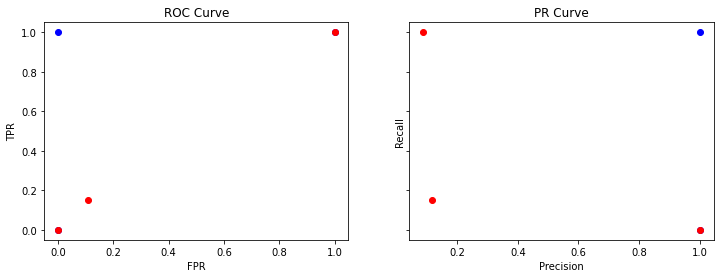

In [ ]:
from sklearn import tree
import time

clf = tree.DecisionTreeClassifier()
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f3 to loss
dtypes: float64(1788), int64(1)
memory usage: 1.4 GB
Time elapsed (Training): 225.8866 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.822233
ROCAUC Score (Validation): 0.518376
Time elapsed (Evaluation): 1.3229 s


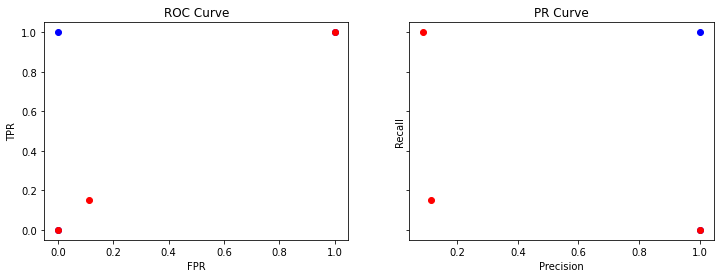

In [ ]:
# Load the training data (imputed and normalized) from the CSV file
df, X, y = load_csv('/content/drive/MyDrive/Colab Notebooks/train_v2_preprocessed_normalized.csv')

# Separate training and validation sets
X_train, y_train, X_valid, y_valid = split_data(kf, X, y)

# Train the model and evaluate
clf = tree.DecisionTreeClassifier()
fit_time =train_model(clf, X_train, y_train)
acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

Time elapsed (Training): 119.6446 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 1.0, 1: 10.0},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.835411
ROCAUC Score (Validation): 0.525845
Time elapsed (Evaluation): 0.8651 s


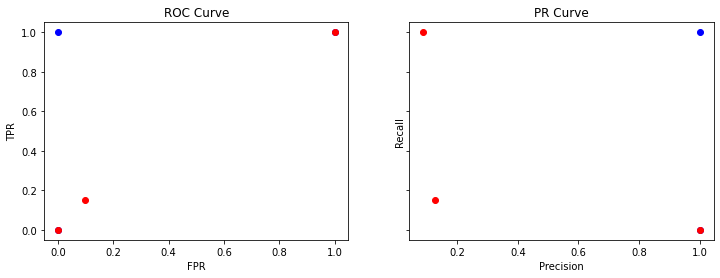

In [ ]:
# Define weights for unbalanced classes

class_weight = {0: 1., 1: 10.}
clf = tree.DecisionTreeClassifier(class_weight=class_weight)
fit_time = train_model(clf, X_train, y_train)
acc_score, rocauc_score,eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)

----- k = 1 -----
Time elapsed (Training): 6.4234 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.598906
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.607797
Time elapsed (Evaluation): 0.7457 s


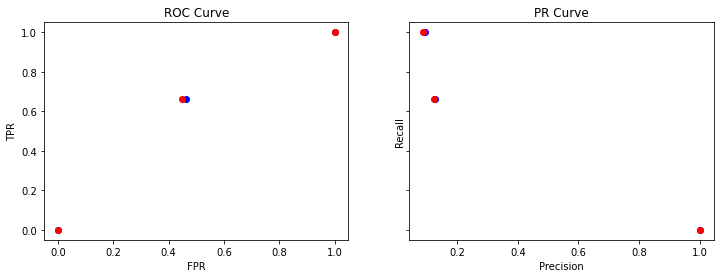

----- k = 2 -----
Time elapsed (Training): 12.6897 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.630998
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.639237
Time elapsed (Evaluation): 0.7483 s


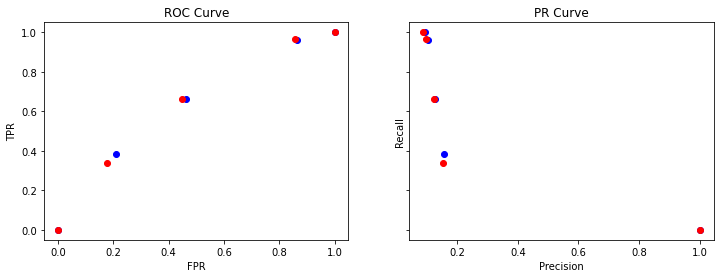

----- k = 3 -----
Time elapsed (Training): 18.9011 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906300
ROCAUC Score (Training): 0.646182
Accuracy (Validation): 0.911970
ROCAUC Score (Validation): 0.647733
Time elapsed (Evaluation): 0.7438 s


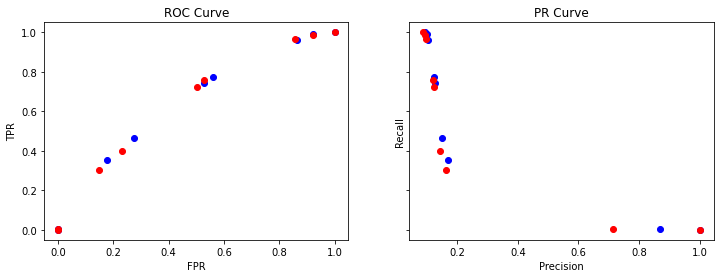

----- k = 4 -----
Time elapsed (Training): 25.2866 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906383
ROCAUC Score (Training): 0.662418
Accuracy (Validation): 0.912017
ROCAUC Score (Validation): 0.646884
Time elapsed (Evaluation): 0.7650 s


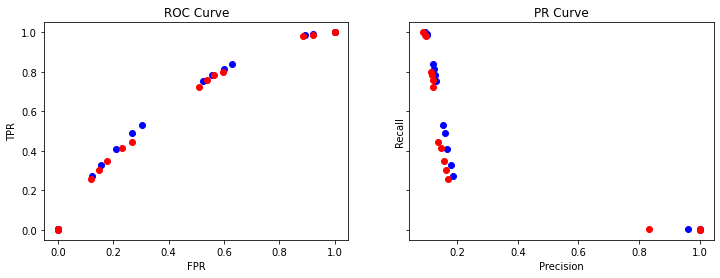

----- k = 5 -----
Time elapsed (Training): 31.6137 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906573
ROCAUC Score (Training): 0.673382
Accuracy (Validation): 0.911780
ROCAUC Score (Validation): 0.653882
Time elapsed (Evaluation): 0.7442 s


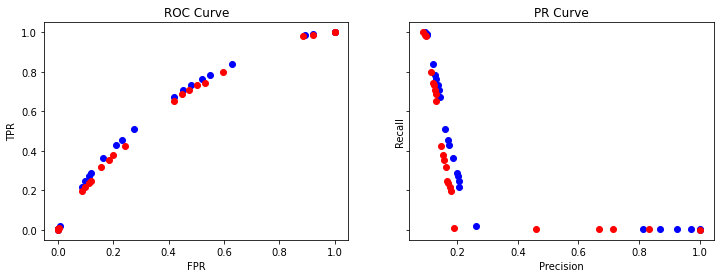

----- k = 6 -----
Time elapsed (Training): 37.4347 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.907071
ROCAUC Score (Training): 0.683001
Accuracy (Validation): 0.911543
ROCAUC Score (Validation): 0.659652
Time elapsed (Evaluation): 0.7415 s


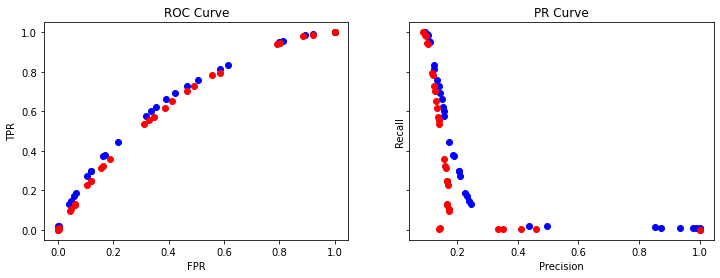

----- k = 7 -----
Time elapsed (Training): 43.5960 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.907640
ROCAUC Score (Training): 0.695737
Accuracy (Validation): 0.911116
ROCAUC Score (Validation): 0.662426
Time elapsed (Evaluation): 0.7667 s


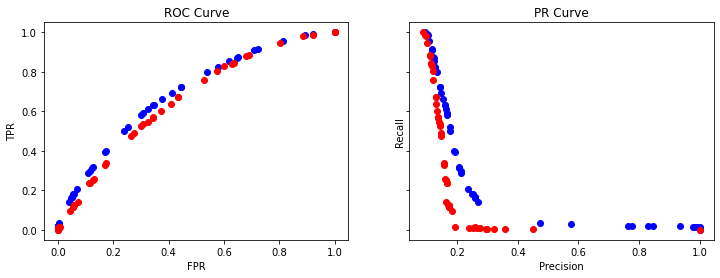

----- k = 8 -----
Time elapsed (Training): 49.5404 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.908766
ROCAUC Score (Training): 0.705474
Accuracy (Validation): 0.909694
ROCAUC Score (Validation): 0.663200
Time elapsed (Evaluation): 0.7660 s


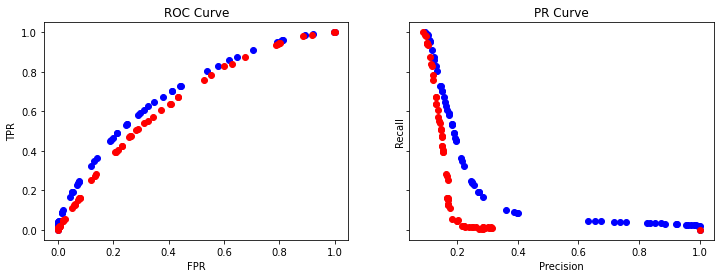

----- k = 9 -----
Time elapsed (Training): 55.6042 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.910674
ROCAUC Score (Training): 0.714159
Accuracy (Validation): 0.908604
ROCAUC Score (Validation): 0.660563
Time elapsed (Evaluation): 1.1706 s


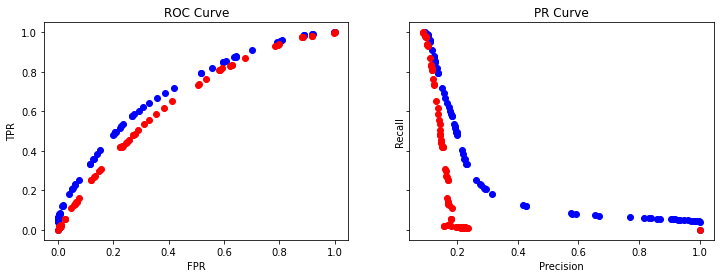

----- k = 10 -----
Time elapsed (Training): 63.0240 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.912783
ROCAUC Score (Training): 0.725379
Accuracy (Validation): 0.905712
ROCAUC Score (Validation): 0.657192
Time elapsed (Evaluation): 0.7635 s


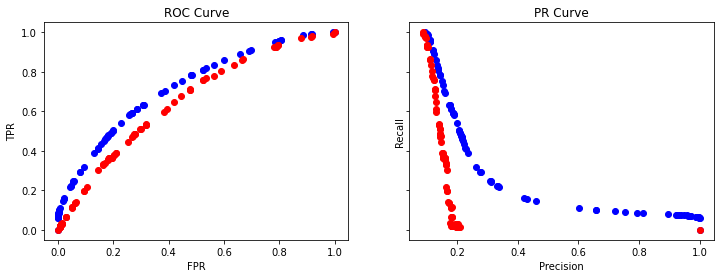

----- k = 11 -----
Time elapsed (Training): 67.7402 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.914798
ROCAUC Score (Training): 0.736660
Accuracy (Validation): 0.904148
ROCAUC Score (Validation): 0.652261
Time elapsed (Evaluation): 0.7392 s


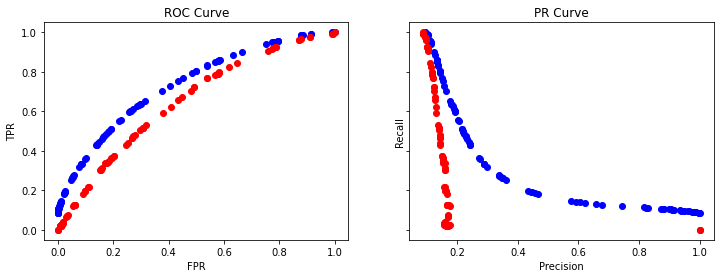

----- k = 12 -----
Time elapsed (Training): 73.5557 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.917239
ROCAUC Score (Training): 0.749884
Accuracy (Validation): 0.903626
ROCAUC Score (Validation): 0.650284
Time elapsed (Evaluation): 0.7617 s


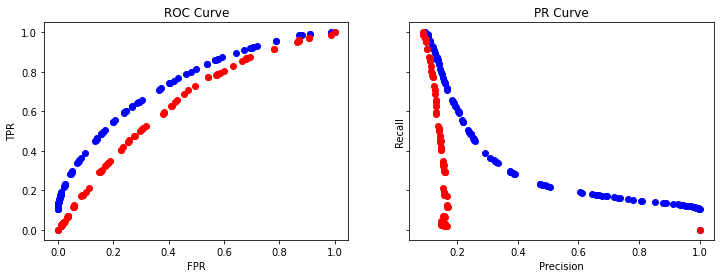

----- k = 13 -----
Time elapsed (Training): 79.3412 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.921127
ROCAUC Score (Training): 0.762420
Accuracy (Validation): 0.899123
ROCAUC Score (Validation): 0.648463
Time elapsed (Evaluation): 0.7578 s


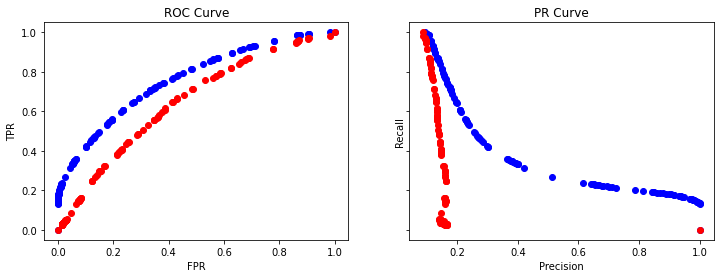

----- k = 14 -----
Time elapsed (Training): 85.1290 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=14, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.925275
ROCAUC Score (Training): 0.777907
Accuracy (Validation): 0.895805
ROCAUC Score (Validation): 0.643661
Time elapsed (Evaluation): 0.7689 s


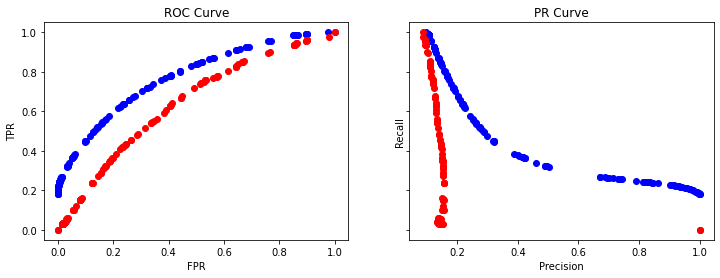

----- k = 15 -----
Time elapsed (Training): 90.7342 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.929885
ROCAUC Score (Training): 0.791136
Accuracy (Validation): 0.893150
ROCAUC Score (Validation): 0.638372
Time elapsed (Evaluation): 0.7776 s


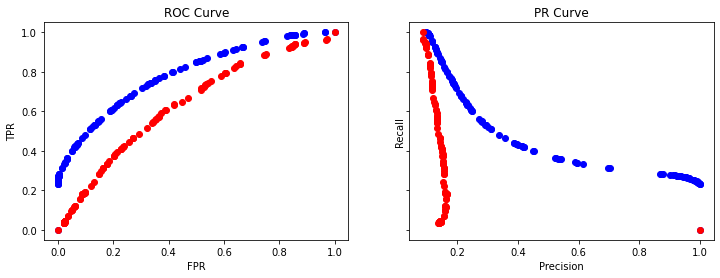

In [ ]:
#max depth
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []; 

for k in ks:
    print('----- k = %d -----' % k)
    clf = tree.DecisionTreeClassifier(max_depth=k)
    fit_time = train_model(clf, X_train, y_train)
    acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score); 

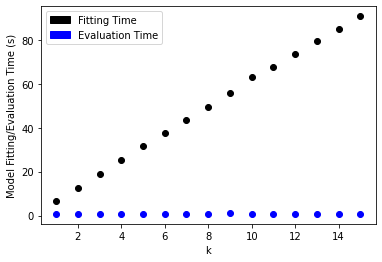

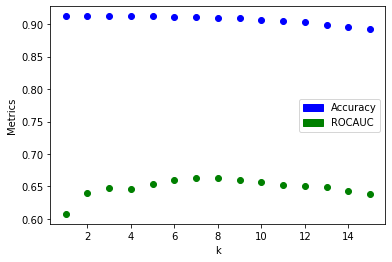

    0_k  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0     1    0.911827  0.607797    6.423400     0.745725
1     2    0.911827  0.639237   12.689700     0.748286
2     3    0.911970  0.647733   18.901059     0.743831
3     4    0.912017  0.646884   25.286579     0.765015
4     5    0.911780  0.653882   31.613744     0.744248
5     6    0.911543  0.659652   37.434730     0.741527
6     7    0.911116  0.662426   43.595970     0.766677
7     8    0.909694  0.663200   49.540440     0.765958
8     9    0.908604  0.660563   55.604168     1.170561
9    10    0.905712  0.657192   63.023960     0.763539
10   11    0.904148  0.652261   67.740228     0.739217
11   12    0.903626  0.650284   73.555721     0.761696
12   13    0.899123  0.648463   79.341152     0.757757
13   14    0.895805  0.643661   85.128983     0.768857
14   15    0.893150  0.638372   90.734249     0.777592


             0_k  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count  15.000000   15.000000  15.000000   15.000000  

In [ ]:
plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores)

----- k = 2 -----
Time elapsed (Training): 227.3296 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.823987
ROCAUC Score (Validation): 0.521280
Time elapsed (Evaluation): 0.8542 s


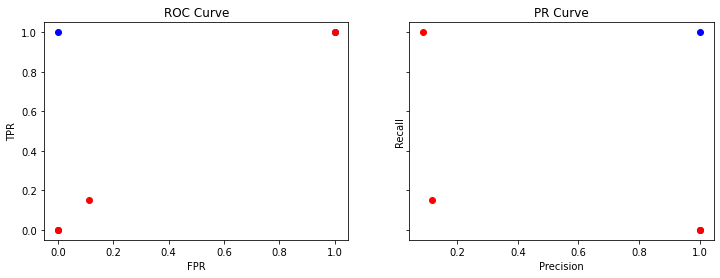

----- k = 5 -----
Time elapsed (Training): 223.6972 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.989938
ROCAUC Score (Training): 0.999281
Accuracy (Validation): 0.828348
ROCAUC Score (Validation): 0.518567
Time elapsed (Evaluation): 0.8322 s


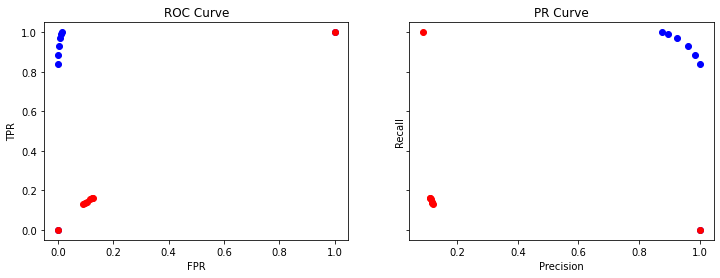

----- k = 10 -----
Time elapsed (Training): 220.4113 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.975420
ROCAUC Score (Training): 0.995499
Accuracy (Validation): 0.830860
ROCAUC Score (Validation): 0.528744
Time elapsed (Evaluation): 0.8296 s


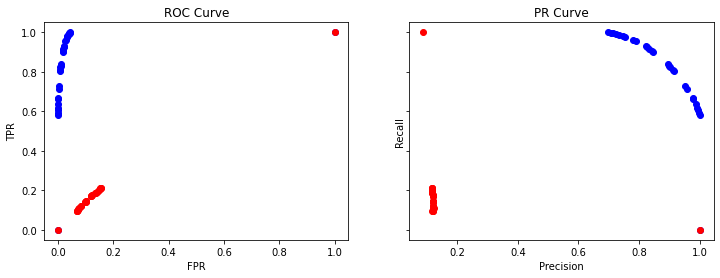

----- k = 20 -----
Time elapsed (Training): 219.3006 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.958412
ROCAUC Score (Training): 0.986891
Accuracy (Validation): 0.838872
ROCAUC Score (Validation): 0.538192
Time elapsed (Evaluation): 0.8253 s


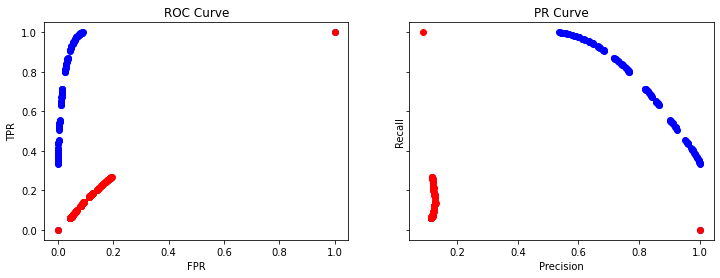

----- k = 50 -----
Time elapsed (Training): 220.3616 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.941275
ROCAUC Score (Training): 0.970644
Accuracy (Validation): 0.857834
ROCAUC Score (Validation): 0.539588
Time elapsed (Evaluation): 0.8262 s


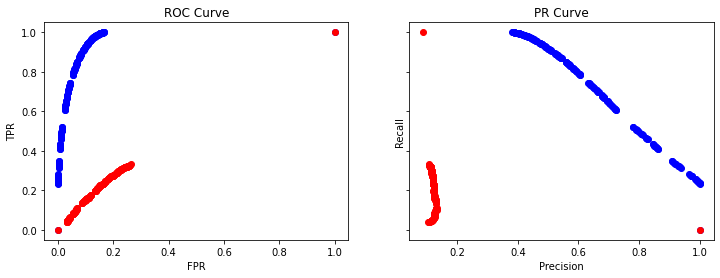

----- k = 100 -----
Time elapsed (Training): 216.9910 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.932433
ROCAUC Score (Training): 0.953431
Accuracy (Validation): 0.871012
ROCAUC Score (Validation): 0.550201
Time elapsed (Evaluation): 0.8224 s


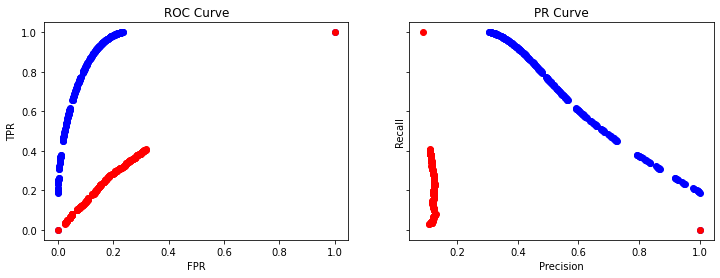

----- k = 200 -----
Time elapsed (Training): 213.2850 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.924090
ROCAUC Score (Training): 0.927354
Accuracy (Validation): 0.882484
ROCAUC Score (Validation): 0.571798
Time elapsed (Evaluation): 0.8289 s


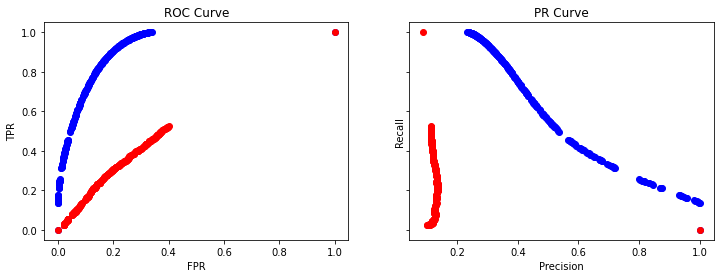

----- k = 500 -----
Time elapsed (Training): 193.1797 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.917287
ROCAUC Score (Training): 0.869654
Accuracy (Validation): 0.894525
ROCAUC Score (Validation): 0.614130
Time elapsed (Evaluation): 0.8140 s


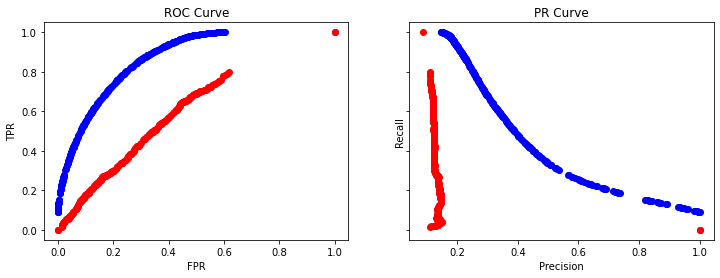

----- k = 1000 -----
Time elapsed (Training): 154.1192 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.911503
ROCAUC Score (Training): 0.795869
Accuracy (Validation): 0.904859
ROCAUC Score (Validation): 0.633190
Time elapsed (Evaluation): 0.7751 s


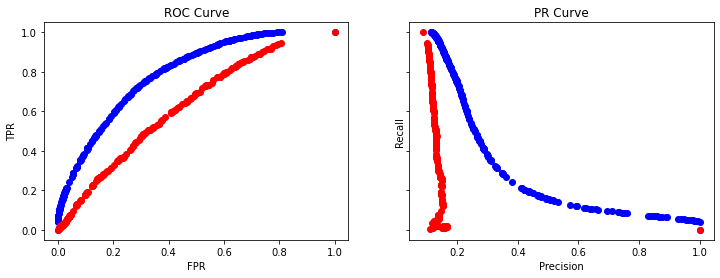

----- k = 2000 -----
Time elapsed (Training): 120.9911 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.908623
ROCAUC Score (Training): 0.747011
Accuracy (Validation): 0.908746
ROCAUC Score (Validation): 0.650719
Time elapsed (Evaluation): 0.7434 s


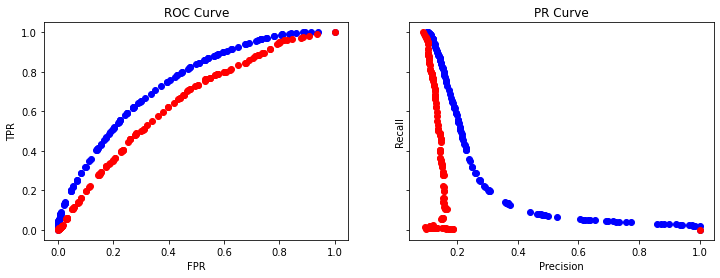

----- k = 5000 -----
Time elapsed (Training): 60.4119 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906739
ROCAUC Score (Training): 0.691891
Accuracy (Validation): 0.911164
ROCAUC Score (Validation): 0.658094
Time elapsed (Evaluation): 0.6861 s


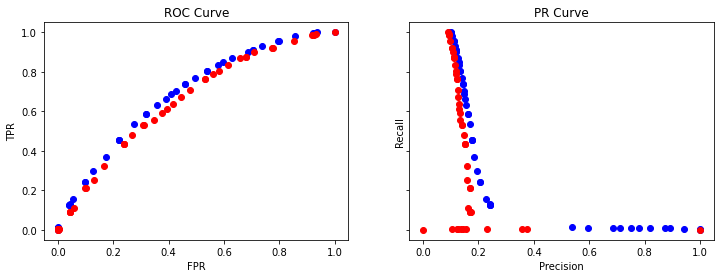

----- k = 10000 -----
Time elapsed (Training): 31.0695 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906360
ROCAUC Score (Training): 0.670834
Accuracy (Validation): 0.911970
ROCAUC Score (Validation): 0.659893
Time elapsed (Evaluation): 0.6876 s


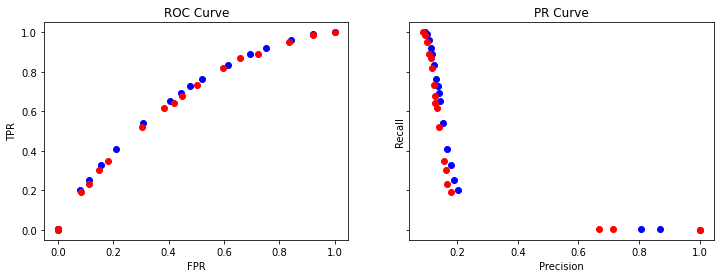

----- k = 20000 -----
Time elapsed (Training): 23.3435 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906360
ROCAUC Score (Training): 0.651903
Accuracy (Validation): 0.911970
ROCAUC Score (Validation): 0.648538
Time elapsed (Evaluation): 0.6659 s


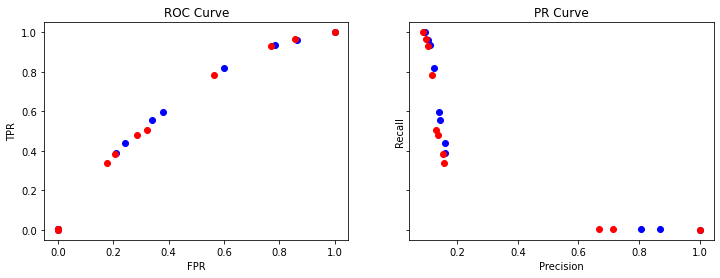

----- k = 50000 -----
Time elapsed (Training): 6.3924 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50000,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.598906
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.607797
Time elapsed (Evaluation): 0.6398 s


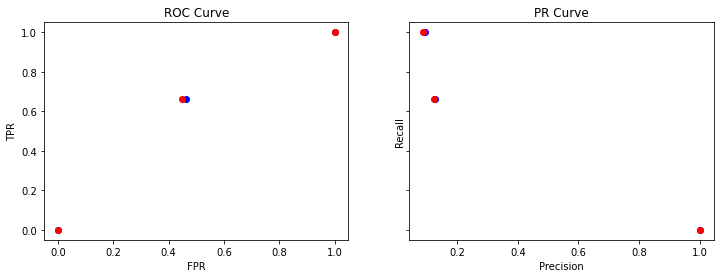

In [ ]:
#min samples split

ks = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = tree.DecisionTreeClassifier(min_samples_split=k)
    fit_time = train_model(clf, X_train, y_train)
    acc_score, rocauc_score,  eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

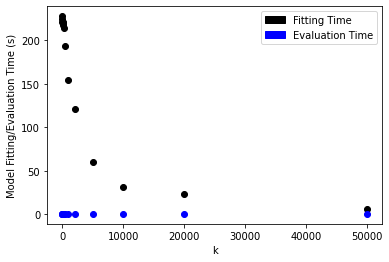

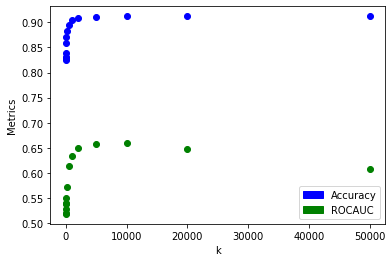

      0_k  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0       2    0.823987  0.521280  227.329579     0.854240
1       5    0.828348  0.518567  223.697164     0.832247
2      10    0.830860  0.528744  220.411279     0.829646
3      20    0.838872  0.538192  219.300594     0.825327
4      50    0.857834  0.539588  220.361565     0.826214
5     100    0.871012  0.550201  216.991037     0.822418
6     200    0.882484  0.571798  213.285036     0.828924
7     500    0.894525  0.614130  193.179736     0.814044
8    1000    0.904859  0.633190  154.119232     0.775061
9    2000    0.908746  0.650719  120.991056     0.743445
10   5000    0.911164  0.658094   60.411946     0.686136
11  10000    0.911970  0.659893   31.069503     0.687581
12  20000    0.911970  0.648538   23.343495     0.665896
13  50000    0.911827  0.607797    6.392417     0.639798


                0_k  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count     14.000000   14.000000  14.000000   14.000000    14.000000
mean   

In [ ]:
plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores)

----- k = 1 -----
Time elapsed (Training): 222.8113 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 1.000000
ROCAUC Score (Training): 1.000000
Accuracy (Validation): 0.824034
ROCAUC Score (Validation): 0.520092
Time elapsed (Evaluation): 0.8353 s


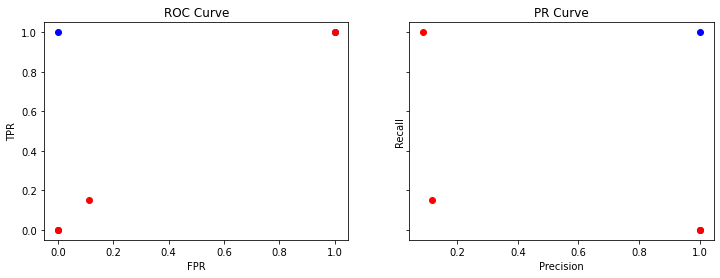

----- k = 2 -----
Time elapsed (Training): 189.5341 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.982531
ROCAUC Score (Training): 0.998165
Accuracy (Validation): 0.843423
ROCAUC Score (Validation): 0.522737
Time elapsed (Evaluation): 0.8143 s


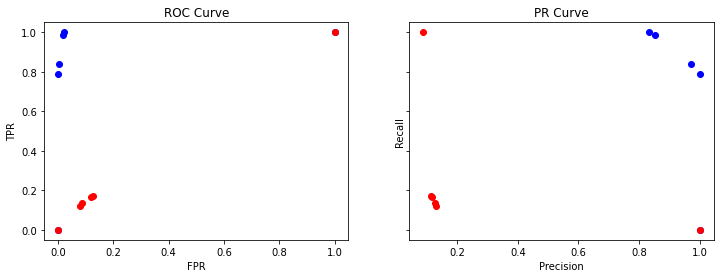

----- k = 5 -----
Time elapsed (Training): 150.1511 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.952463
ROCAUC Score (Training): 0.982718
Accuracy (Validation): 0.850438
ROCAUC Score (Validation): 0.532311
Time elapsed (Evaluation): 0.7902 s


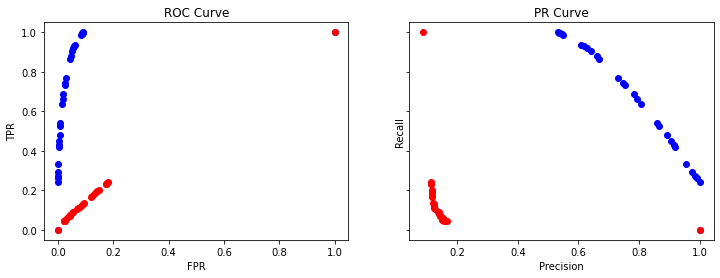

----- k = 10 -----
Time elapsed (Training): 124.3605 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.929127
ROCAUC Score (Training): 0.957402
Accuracy (Validation): 0.867883
ROCAUC Score (Validation): 0.547887
Time elapsed (Evaluation): 0.7817 s


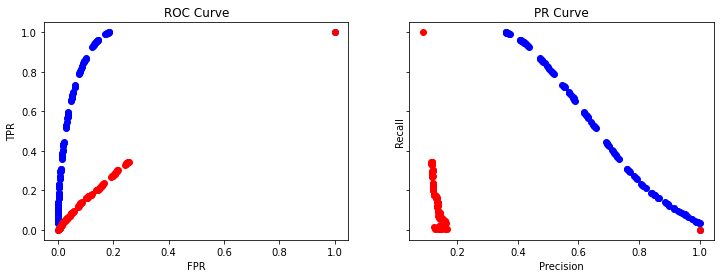

----- k = 20 -----
Time elapsed (Training): 106.2730 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.913933
ROCAUC Score (Training): 0.920448
Accuracy (Validation): 0.890116
ROCAUC Score (Validation): 0.548154
Time elapsed (Evaluation): 0.9236 s


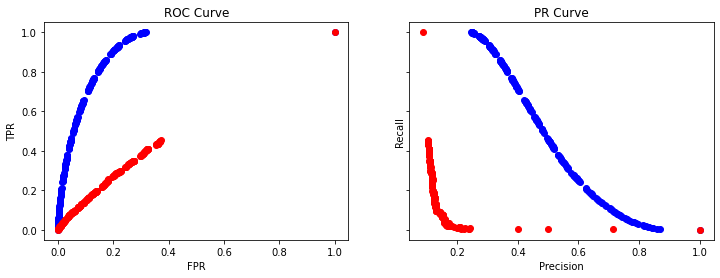

----- k = 50 -----
Time elapsed (Training): 85.1635 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906703
ROCAUC Score (Training): 0.860150
Accuracy (Validation): 0.906329
ROCAUC Score (Validation): 0.589869
Time elapsed (Evaluation): 0.7444 s


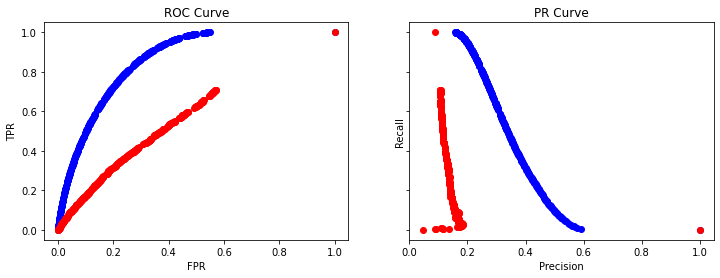

----- k = 100 -----
Time elapsed (Training): 70.9051 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.809431
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.616865
Time elapsed (Evaluation): 0.7201 s


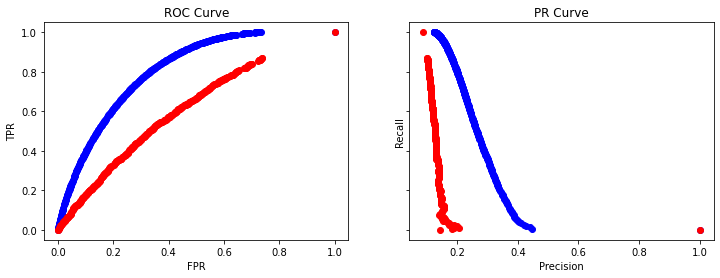

----- k = 200 -----
Time elapsed (Training): 59.7734 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.762357
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.639870
Time elapsed (Evaluation): 0.7236 s


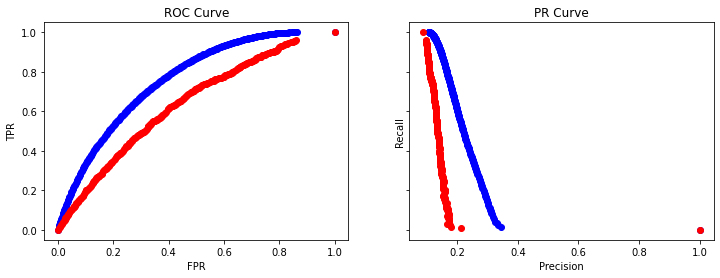

----- k = 500 -----
Time elapsed (Training): 48.3980 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=500, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.721404
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.653344
Time elapsed (Evaluation): 0.6827 s


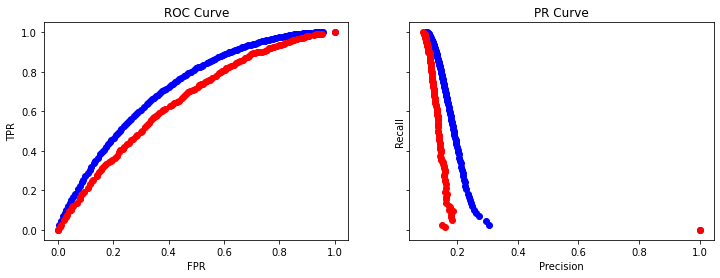

----- k = 1000 -----
Time elapsed (Training): 41.0278 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.699285
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.666360
Time elapsed (Evaluation): 0.6696 s


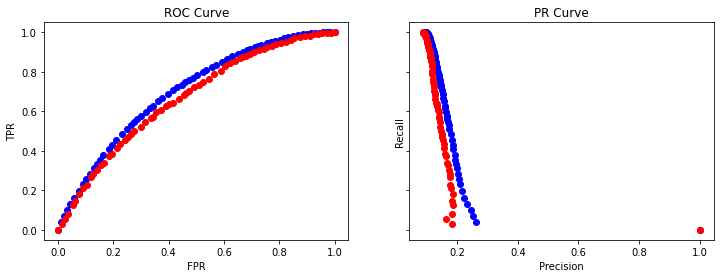

----- k = 2000 -----
Time elapsed (Training): 33.1995 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.682214
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.663636
Time elapsed (Evaluation): 0.6534 s


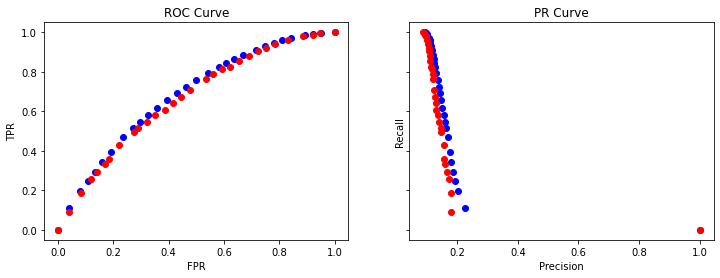

----- k = 5000 -----
Time elapsed (Training): 23.3000 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.661293
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.659473
Time elapsed (Evaluation): 0.6776 s


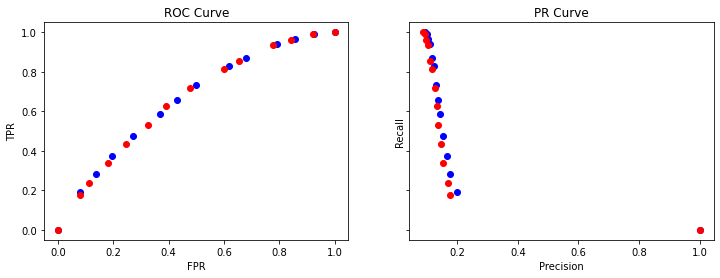

----- k = 10000 -----
Time elapsed (Training): 17.2305 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.648632
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.653527
Time elapsed (Evaluation): 0.6499 s


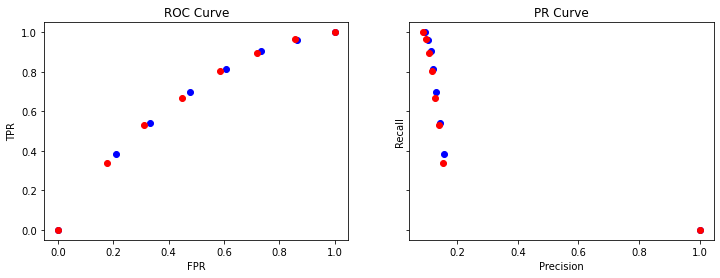

----- k = 20000 -----
Time elapsed (Training): 11.6768 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.632089
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.638348
Time elapsed (Evaluation): 0.6330 s


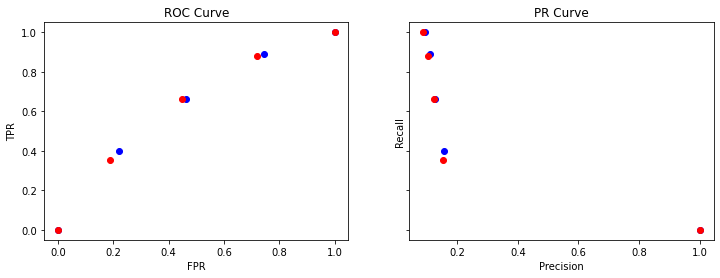

----- k = 50000 -----
Time elapsed (Training): 0.2391 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50000, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.500000
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.500000
Time elapsed (Evaluation): 0.6457 s


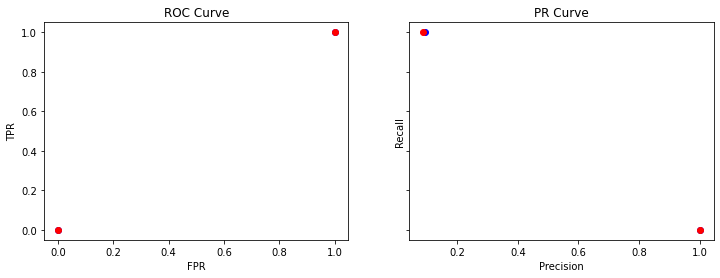

In [ ]:
#min samples leaf
ks = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = tree.DecisionTreeClassifier(min_samples_leaf=k)
    fit_time =train_model(clf, X_train, y_train)
    acc_score, rocauc_score,eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

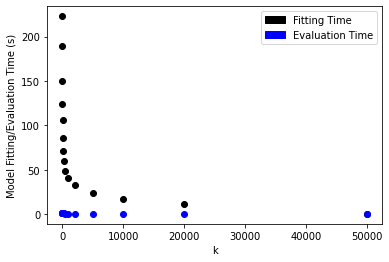

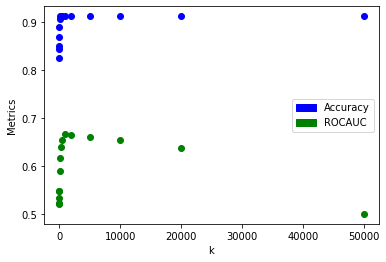

      0_k  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0       1    0.824034  0.520092  222.811333     0.835296
1       2    0.843423  0.522737  189.534091     0.814303
2       5    0.850438  0.532311  150.151135     0.790187
3      10    0.867883  0.547887  124.360495     0.781735
4      20    0.890116  0.548154  106.272967     0.923627
5      50    0.906329  0.589869   85.163527     0.744423
6     100    0.911827  0.616865   70.905138     0.720133
7     200    0.911827  0.639870   59.773384     0.723556
8     500    0.911827  0.653344   48.397990     0.682681
9    1000    0.911827  0.666360   41.027797     0.669606
10   2000    0.911827  0.663636   33.199467     0.653364
11   5000    0.911827  0.659473   23.299962     0.677583
12  10000    0.911827  0.653527   17.230489     0.649917
13  20000    0.911827  0.638348   11.676803     0.633010
14  50000    0.911827  0.500000    0.239088     0.645729


                0_k  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count     15.00000

In [ ]:
plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores)

----- k = 2 -----
Time elapsed (Training): 13.4236 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=2,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906099
ROCAUC Score (Training): 0.598906
Accuracy (Validation): 0.911827
ROCAUC Score (Validation): 0.607797
Time elapsed (Evaluation): 0.8425 s


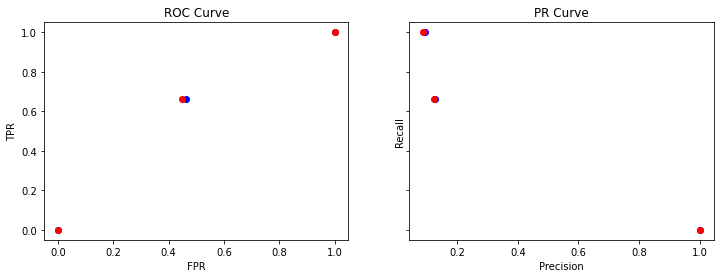

----- k = 5 -----
Time elapsed (Training): 20.6718 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906300
ROCAUC Score (Training): 0.631829
Accuracy (Validation): 0.911970
ROCAUC Score (Validation): 0.640027
Time elapsed (Evaluation): 0.7256 s


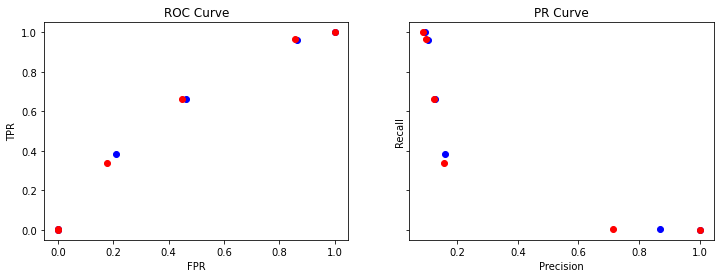

----- k = 10 -----
Time elapsed (Training): 28.4080 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906300
ROCAUC Score (Training): 0.653595
Accuracy (Validation): 0.911970
ROCAUC Score (Validation): 0.650644
Time elapsed (Evaluation): 0.7251 s


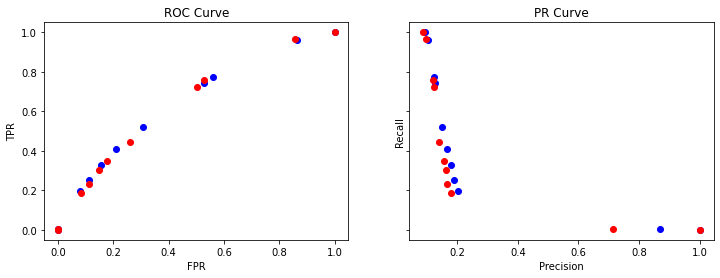

----- k = 20 -----
Time elapsed (Training): 37.1972 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.906360
ROCAUC Score (Training): 0.672658
Accuracy (Validation): 0.911970
ROCAUC Score (Validation): 0.658961
Time elapsed (Evaluation): 0.7351 s


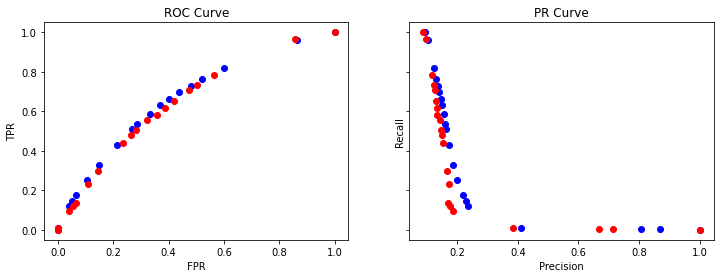

----- k = 50 -----
Time elapsed (Training): 45.1863 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=50,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.907509
ROCAUC Score (Training): 0.684268
Accuracy (Validation): 0.910595
ROCAUC Score (Validation): 0.662114
Time elapsed (Evaluation): 0.7502 s


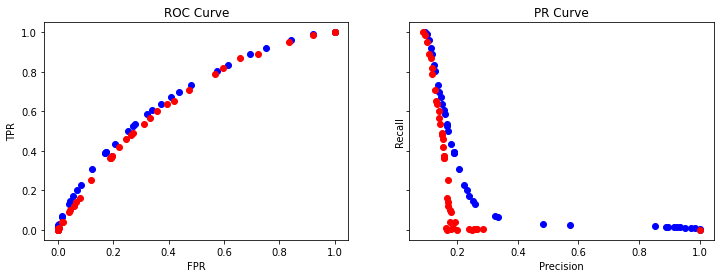

----- k = 100 -----
Time elapsed (Training): 49.9223 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.909560
ROCAUC Score (Training): 0.691636
Accuracy (Validation): 0.909220
ROCAUC Score (Validation): 0.663469
Time elapsed (Evaluation): 0.7401 s


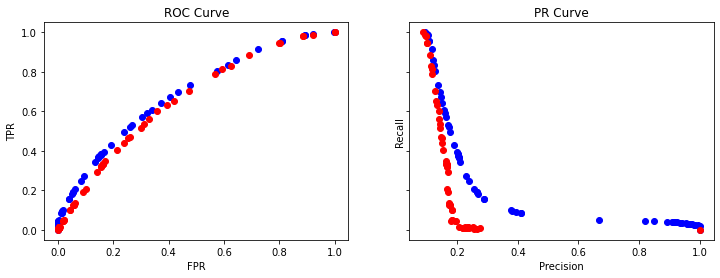

----- k = 200 -----
Time elapsed (Training): 56.6672 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=200,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.913613
ROCAUC Score (Training): 0.705526
Accuracy (Validation): 0.906755
ROCAUC Score (Validation): 0.662449
Time elapsed (Evaluation): 0.7396 s


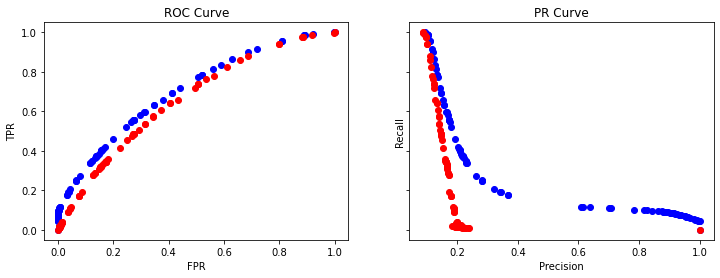

----- k = 500 -----
Time elapsed (Training): 69.7911 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=500,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.923639
ROCAUC Score (Training): 0.738910
Accuracy (Validation): 0.898839
ROCAUC Score (Validation): 0.655969
Time elapsed (Evaluation): 0.7518 s


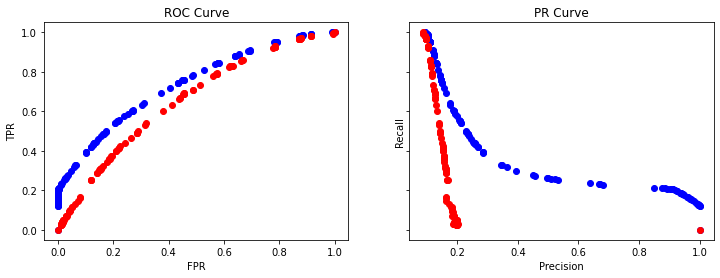

----- k = 1000 -----
Time elapsed (Training): 84.5172 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=1000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.937909
ROCAUC Score (Training): 0.773609
Accuracy (Validation): 0.886513
ROCAUC Score (Validation): 0.624817
Time elapsed (Evaluation): 0.7804 s


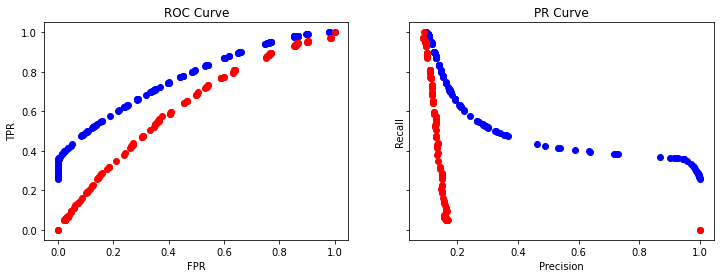

----- k = 2000 -----
Time elapsed (Training): 116.6895 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=2000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.958163
ROCAUC Score (Training): 0.860071
Accuracy (Validation): 0.864612
ROCAUC Score (Validation): 0.551950
Time elapsed (Evaluation): 0.8128 s


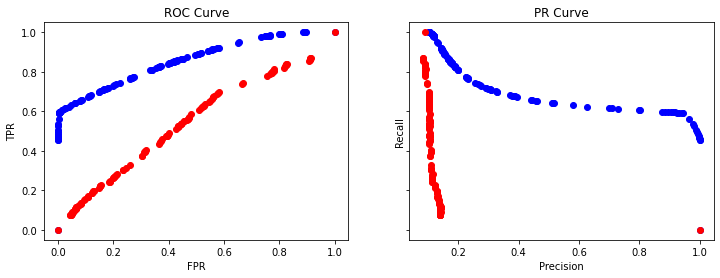

----- k = 5000 -----
Time elapsed (Training): 224.2047 s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy (Training): 0.993375
ROCAUC Score (Training): 0.983167
Accuracy (Validation): 0.834700
ROCAUC Score (Validation): 0.463831
Time elapsed (Evaluation): 1.0955 s


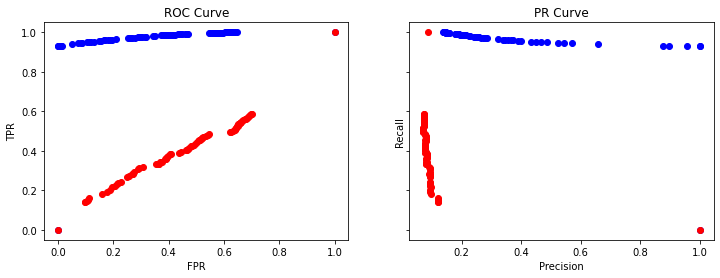

In [ ]:
#max leaf nodes
ks = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
fit_times = []; eval_times = []; acc_scores = []; rocauc_scores = []

for k in ks:
    print('----- k = %d -----' % k)
    clf = tree.DecisionTreeClassifier(max_leaf_nodes=k)
    fit_time =train_model(clf, X_train, y_train)
    acc_score, rocauc_score, eval_time = evaluate(clf, X_train, y_train, X_valid, y_valid)
    fit_times.append(fit_time); eval_times.append(eval_time)
    acc_scores.append(acc_score); rocauc_scores.append(rocauc_score)

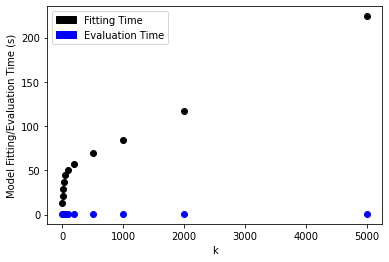

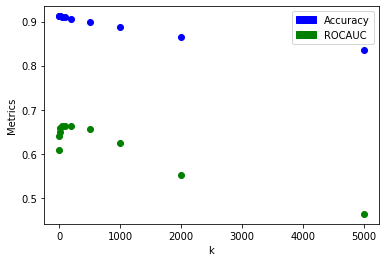

     0_k  1_Accuracy  2_ROCAUC  4_fit_time  5_eval_time
0      2    0.911827  0.607797   13.423561     0.842505
1      5    0.911970  0.640027   20.671800     0.725613
2     10    0.911970  0.650644   28.408036     0.725055
3     20    0.911970  0.658961   37.197211     0.735090
4     50    0.910595  0.662114   45.186270     0.750212
5    100    0.909220  0.663469   49.922313     0.740110
6    200    0.906755  0.662449   56.667177     0.739599
7    500    0.898839  0.655969   69.791127     0.751787
8   1000    0.886513  0.624817   84.517158     0.780415
9   2000    0.864612  0.551950  116.689512     0.812837
10  5000    0.834700  0.463831  224.204686     1.095472


               0_k  1_Accuracy   2_ROCAUC  4_fit_time  5_eval_time
count    11.000000   11.000000  11.000000   11.000000    11.000000
mean    807.909091    0.896270   0.622003   67.879895     0.790790
std    1520.629505    0.025217   0.062261   59.797175     0.107762
min       2.000000    0.834700   0.463831   13.423561     

In [ ]:
plot_metrics(ks, 'k', False, fit_times, eval_times, acc_scores, rocauc_scores)